In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import torch
from torch import Tensor

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda


In [3]:
start = time.time()

In [4]:
history = 300 #specify the number of particles
radius = 5
r = torch.full((history, 2), float('nan')).to(device)

def initialize_particles(r, history):
    for i in range(history):
        teta = np.random.uniform(0, 2*np.pi)
        position = np.random.uniform(0, radius)
        r[i, 0] = position * np.cos(teta)
        r[i, 1] = position * np.sin(teta)

In [5]:
initialize_particles(r, history)

In [6]:
r.device

device(type='cuda', index=0)

In [7]:
fps = 20
dt = 1/fps
final_time = 200
steps = int(final_time/dt)

In [8]:
record = torch.full((steps, history, 2), float('nan')).to(device)
record[0,:,:] = r[:,:]
init_record = record

In [9]:
fr = 1
fuel = torch.full((1, 2), float('nan')).to(device)

def initialize_fuel():
    fuel[0, 0] = 0
    fuel[0, 1] = 0

In [10]:
initialize_fuel()

In [11]:
speed = 1
v = torch.full((history, 2), float('nan')).to(device)

def initialize_speed(v, history):
    for i in range(history):
        teta = np.random.uniform(0, 2*np.pi)
        v[i, 0] = speed * np.cos(teta)
        v[i, 1] = speed * np.sin(teta)

In [12]:
initialize_speed(v, history)

In [13]:
for i in range(1, steps):
    for j in range(history):
        if r[j, 0] == 11000:
            continue
        elif (fuel[0, 0] - fr <= r[j, 0] <= fuel[0, 0] + fr and
              fuel[0, 1] - fr <= r[j, 1] <= fuel[0, 1] + fr and
              torch.sqrt(r[j, 0]**2 + r[j, 1]**2) <= fr):
            r[j,:] = 11000
            v[j,:] = 0
            r2 = torch.full((2, 2), float('nan')).to(device)
            initialize_particles(r2, 2)
            v2 = torch.full((2, 2), float('nan')).to(device)
            initialize_speed(v2, 2)
            r = torch.cat((r, r2), dim=0)
            v = torch.cat((v, v2), dim=0)
            history += 2
            record = torch.full((steps, history, 2), float('nan')).to(device)
            record[:, :history-2, :] = init_record
            init_record = record
            continue
        elif torch.sqrt(r[j, 0]**2 + r[j, 1]**2) < radius:
                r[j, :] = r[j, :] + v[j, :] * dt
                continue
        else:
            distance_to_origin = torch.sqrt(r[j, 0]**2 + r[j, 1]**2)
            normal_vector = (r[j] / distance_to_origin)
            dot_product = torch.dot(v[j], normal_vector)
            v[j, 0] -= 2 * dot_product * normal_vector[0]
            v[j, 1] -= 2 * dot_product * normal_vector[1]
            r[j, :] = r[j, :] + v[j, :] * dt
    record[i,:,:] = r[:,:]
    init_record = record

In [14]:
end = time.time()
print(f'duration = {end-start}')

duration = 1099.9044981002808


In [15]:
record.shape

torch.Size([4000, 1682, 2])

In [16]:
record = record.detach().cpu().numpy()

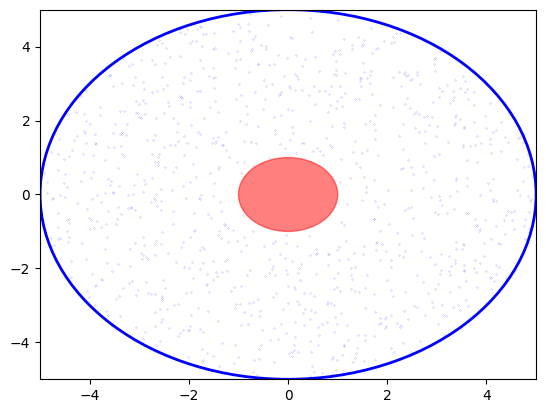

In [17]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)

# Create a scatter plot for the particles with a specified size (e.g., ms=2)
particles, = ax.plot([], [], 'bo', ms=0.1)

# Create cylinder boundary
cylinder = plt.Circle((0, 0), radius, color='b', fill=False, lw=2)
ax.add_patch(cylinder)

# Create fuel region
fuel_region = plt.Circle((0, 0), fr, color='red', alpha=0.5)
ax.add_patch(fuel_region)

# Function to initialize the plot
def init():
    particles.set_data([], [])
    return particles,

# Function to update particle positions for each frame
def update(frame):
    x_data = record[frame,:,0].copy()
    y_data = record[frame,:,1].copy()
    particles.set_data(x_data, y_data)
    return particles,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(record), init_func=init, interval=50, blit=True)

# Set up the animation writer (for saving as a GIF)
Writer = animation.writers['pillow']
writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)

# Save the animation as a GIF
ani.save('particle_animation.gif', writer=writer)

# Display the animation
plt.show()
